In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import unicodedata
import re
print(tf.__version__)

2.3.0


In [2]:
!ls

 _about.txt	     deu-eng.zip   ECG.ipynb
 Autoencoder.ipynb   deu.txt	  "utf-8''Capstone Project.ipynb"


In [3]:
# These functions preprocess English and German sentences

def unicode_to_ascii(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s) if unicodedata.category(c) != 'Mn')

def preprocess_sentence(sentence):
    sentence = sentence.lower().strip()
    sentence = re.sub(r"ü", 'ue', sentence)
    sentence = re.sub(r"ä", 'ae', sentence)
    sentence = re.sub(r"ö", 'oe', sentence)
    sentence = re.sub(r'ß', 'ss', sentence)
    
    sentence = unicode_to_ascii(sentence)
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = re.sub(r"[^a-z?.!,']+", " ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)
    
    return sentence.strip()

In [7]:
data = []
with open('deu.txt') as f:
    for row in f:
        data.append(row)

In [8]:
sentences =[]
for i in data:
    sentences.append(i.split("	"))

sentences[5]

['Wow!',
 'Potzdonner!',
 'CC-BY 2.0 (France) Attribution: tatoeba.org #52027 (Zifre) & #2122382 (Pfirsichbaeumchen)\n']

In [9]:
english_sentences=[]
german_sentences =[]
for s in sentences:
    english_sentences.append(s[0])
    german_sentences.append(s[1])
   

index=10000

print(english_sentences[index], german_sentences[index])

Tom was gentle. Tom war sanft.


In [10]:
start_token = '<start>'
end_token = '<end>'

for es in english_sentences:
    es=preprocess_sentence(es)
    
for gs in german_sentences:
    gs=start_token+preprocess_sentence(gs)+end_token


In [11]:
print(english_sentences[index+1], german_sentences[index+1])

Tom was greedy. Tom war gierig.


In [12]:
from tensorflow.keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer(filters='')
tokenizer.fit_on_texts(german_sentences)
    
    
from tensorflow.keras.preprocessing.sequence import pad_sequences

sequences = tokenizer.texts_to_sequences(german_sentences)
padded = pad_sequences(sequences, padding='post',value=0)

In [13]:
def logits_to_text(logits, tokenizer):
    index_to_words = {id: word for word, id in tokenizer.word_index.items()}
    index_to_words[0] = '<PAD>'

    return ' '.join([index_to_words[prediction] for prediction in np.argmax(logits, 1)])

In [15]:
from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import Dense, Flatten, Reshape

class Autoencoder(Model):
    def __init__(self, latent_dim, **kwargs):
        super(Autoencoder, self).__init__(**kwargs)
        self.latent_dim = latent_dim
        self.encoder=Sequential([
            Flatten(),
            Dense(latent_dim, activation='relu')
        ])
        self.decoder = Sequential([
            Dense(784, activation='sigmoid'),
        ])
    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded
autoencoder = Autoencoder(64)

In [16]:
autoencoder.compile(optimizer='adam', 
                    loss='mean_squared_error', 
                    metrics=['accuracy', 'val_accuracy'])


In [17]:
autoencoder.decoder.summary()

ValueError: This model has not yet been built. Build the model first by calling `build()` or calling `fit()` with some data, or specify an `input_shape` argument in the first layer(s) for automatic build.

In [53]:
autoencoder.fit(x_train, y_train, epochs=10, shuffle=True, validation_data=(x_test, y_test))

Epoch 1/10
1875/1875 [==============================] - 4s 2ms/step - loss: 20.5295 - val_loss: 20.5000
Epoch 2/10
1875/1875 [==============================] - 4s 2ms/step - loss: 20.5000 - val_loss: 20.5000
Epoch 3/10
1875/1875 [==============================] - 4s 2ms/step - loss: 20.5000 - val_loss: 20.5000
Epoch 4/10
1875/1875 [==============================] - 4s 2ms/step - loss: 20.5000 - val_loss: 20.5000
Epoch 5/10
1875/1875 [==============================] - 4s 2ms/step - loss: 20.5000 - val_loss: 20.5000
Epoch 6/10
1875/1875 [==============================] - 4s 2ms/step - loss: 20.5000 - val_loss: 20.5000
Epoch 7/10
1875/1875 [==============================] - 4s 2ms/step - loss: 20.5000 - val_loss: 20.5000
Epoch 8/10
1875/1875 [==============================] - 4s 2ms/step - loss: 20.5000 - val_loss: 20.5000
Epoch 9/10
1875/1875 [==============================] - 4s 2ms/step - loss: 20.5000 - val_loss: 20.5000
Epoch 10/10
1875/1875 [==============================] - 4s 2ms/

In [84]:
model = Sequential([
    GRU(256, input_shape=input_shape[-1], return_sequences=True)
    TimeDistributed(Dense(1024, activation='relu')),
    Dropout(0.3),
    TimeDistributed(Dense(1, activation='sigmoid'))  
])
model.compile(loss='sparse_categorical_crossentropy',
                  optimizer='adam'
                  metrics=['accuracy'])

SyntaxError: invalid syntax (<ipython-input-84-64c577a01a55>, line 3)

In [57]:
encoded_imgs = autoencoder.encoder(x_test).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

TypeError: Invalid shape (784,) for image data

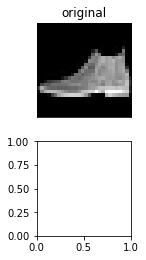

In [58]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
  # display original
  ax = plt.subplot(2, n, i + 1)
  plt.imshow(x_test[i])
  plt.title("original")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  # display reconstruction
  ax = plt.subplot(2, n, i + 1 + n)
  plt.imshow(decoded_imgs[i])
  plt.title("reconstructed")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()